In [1]:
import numpy as np
import mat73
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.signal import butter, filtfilt, sosfiltfilt
from sklearn.model_selection import train_test_split

### Filters


In [2]:
def butter_lowpass_filter(data, lowcut, fs, order):
    nyq = fs/2
    low = lowcut/nyq
    b, a = butter(order, low, btype='low')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
    return y

In [3]:
def butter_highpass_filter(data, highcut, fs, order):
    nyq = fs/2
    high = highcut/nyq
    b, a = butter(order, high, btype='high')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
    return y

In [4]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = fs/2
    low = lowcut/nyq
    high = highcut/nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = sosfiltfilt(sos, data) # zero-phase filter # data: [ch x time]
    # specify pandlen to make the result the same as Matlab filtfilt()
    return y

### Preprocessing

In [5]:
def extractEpoch3D(data, event, srate, baseline, frame, opt_keep_baseline):
    # extract epoch from 2D data into 3D [ch x time x trial]
    # input: event, baseline, frame
    # extract epoch = baseline[0] to frame[2]   so the time frame is -200 to 600 ms.

    # for memory pre-allocation
    if opt_keep_baseline == True:
        begin_tmp = int(np.floor(baseline[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-baseline[0])/1000*srate)
    else:
        begin_tmp = int(np.floor(frame[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-frame[0])/1000*srate)

    epoch3D = np.zeros((data.shape[0], end_tmp-begin_tmp, len(event)))
    nth_event = 0 # trial

    for i in event:
        if opt_keep_baseline == True:
            begin_id = int(i + np.floor(baseline[0]/1000 * srate))                 # int(i + begin_tmp)
            end_id = int(begin_id + np.floor((frame[1]-baseline[0])/1000*srate))   # int(i + end_tmp)
        else:
            begin_id = int(i + np.floor(frame[0]/1000 * srate))
            end_id = int(begin_id + np.floor((frame[1]-frame[0])/1000*srate))

        tmp_data = data[:, begin_id:end_id] # extract the time period

        begin_base = int(np.floor(baseline[0]/1000 * srate))+i
        end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)
        base = np.mean(data[:, begin_base:end_base], axis=1)

        rmbase_data = tmp_data - base[:, np.newaxis]
        epoch3D[:, :, nth_event] = rmbase_data
        nth_event = nth_event + 1

    return epoch3D

In [6]:
def decimation_by_avg(data, factor):
    """Function for replacing each sequence of previous factor samples with their average"""
    # for example, frame [0, 800]ms -> 17samples (Krusienski et al., 2006)
    # data.shape = [ch, time, trial]
    ratio_dsample = factor
    n_ch, n_frame, n_trial = data.shape

    print("n_frame" ,n_frame)
    decimated_frame = int(np.floor(n_frame/ratio_dsample))
    print("decimated_frame ",decimated_frame)

    # memory pre-allocation
    decimated_data = np.zeros((n_ch, decimated_frame, n_trial))
    print("decimated_data.shape ",decimated_data.shape)

    for i in range(n_trial):
        for j in range(decimated_frame):
            cur_data = data[:, :, i]
            decimated_data[:, j, i] = np.mean(cur_data[:, j*ratio_dsample:(j+1)*ratio_dsample], axis=1)

    return decimated_data

In [7]:
def detect_letter_P3speller(pred_score, word_len, label, letter_ind, markers_seq, params):
    """Function for detecing letter from the predicted results from unknown EEG"""
    user_answer = np.chararray(word_len,1)
    acc_on_repetition = np.zeros(params["full_repeat"])
    correct_on_repetition = np.zeros(params["full_repeat"])
    for n_repeat in range(params["full_repeat"]):
        for n_letter in range(word_len):
            # begin and end trial for a single letter session
            begin_trial = len(params["seq_code"]) * params["full_repeat"] * (n_letter)
            end_trial = begin_trial + (n_repeat+1) * len(params["seq_code"])

            unknown_speller_code = np.zeros(len(params["seq_code"]))
            for j in range(begin_trial, end_trial):
                # predict and add lda score
                unknown_speller_code[int(markers_seq[letter_ind[j]])-1] = unknown_speller_code[int(markers_seq[letter_ind[j]])-1] + pred_score[j]

            row = np.argmax(unknown_speller_code[0:6])
            col = np.argmax(unknown_speller_code[6:12])
            user_answer[n_letter] = params['spellermatrix'][row*6+col]
        user_answer_string = user_answer.tobytes().decode()

        correct_on_repetition[n_repeat] = len([i for i, j in zip(user_answer_string, label) if i == j])
        acc_on_repetition[n_repeat] = correct_on_repetition[n_repeat] / len(label)

    out = {"text_result": user_answer_string, "acc_on_repetition": acc_on_repetition, "correct_on_repetition": correct_on_repetition}
    return out

In [8]:
# pre-defined parameters
baseline = [-200, 0] # in ms
frame = [0, 600] # in ms

In [9]:
EEG = mat73.loadmat("/Volumes/Yohan's_T7/FYP/Datasets/P300 Speller/s01.mat")

### Classifier

In [10]:
def get_stats(dat, x_columns, y):
    x = dat[:, x_columns]
    results = sm.OLS(y, x).fit()
    return results

def stepwise_linear_model(dat, init_x_column, y_train, p_val):
    x_column = init_x_column

    while True:
        results_stats = get_stats(dat, x_column, y_train)
        if np.max(results_stats.pvalues) <= p_val:
            break
        else:
            backward_elim = np.argmax(results_stats.pvalues)
            x_column = np.delete(x_column, backward_elim)

    return x_column, results_stats


### **Visualizaion**

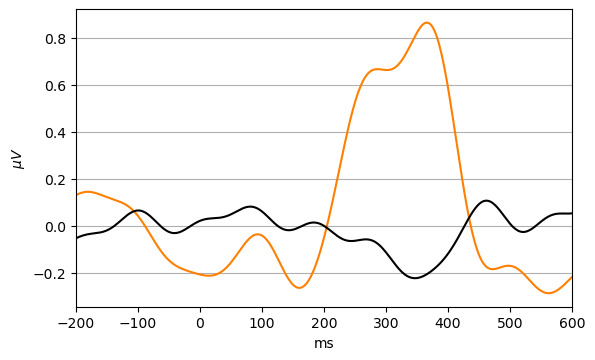

In [11]:
for n_calib in range(len(EEG['test'])):
  cur_EEG = EEG['test'][n_calib]
  data = np.asarray(cur_EEG['data'])
  srate = cur_EEG['srate']
  data = butter_bandpass_filter(data, 1, 10, srate, 4)
  markers = cur_EEG['markers_target']

  targetID = np.where(markers==1)[0]
  nontargetID = np.where(markers==2)[0]

  tmp_targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, True)
  tmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, True)
  if n_calib == 0:
    targetEEG = tmp_targetEEG
    nontargetEEG = tmp_nontargetEEG
  else:
    targetEEG = np.dstack((targetEEG, tmp_targetEEG))
    nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))

avg_target = np.mean(targetEEG, axis=2) # trial average
avg_nontarget = np.mean(nontargetEEG, axis=2) # trial average

# Channel selection for drawing ERPs
elec_midline = [31-1, 32-1, 13-1] # Fz, Cz, and Pz, respectively, -1 for indexing
ch_avg_target = np.mean(avg_target[elec_midline, :], axis=0)
ch_avg_nontarget = np.mean(avg_nontarget[elec_midline, :], axis=0)

# Single subject averaged target & nontarget ERPs - visualization
t = np.linspace(-200, 600, avg_target.shape[1])
plt.plot(t, ch_avg_target.transpose(), color=[1, 0.5, 0])
plt.plot(t, ch_avg_nontarget.transpose(), color=[0, 0, 0])
plt.xlabel('ms')
plt.ylabel(r'$\mu V$')
plt.gca().yaxis.grid(True)
plt.rcParams.update({'font.size': 13})
plt.xlim([-200, 600])

# plot ratio
ratio = .6
x_left, x_right = plt.gca().get_xlim()
y_low, y_high = plt.gca().get_ylim()

plt.gca().set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.show()

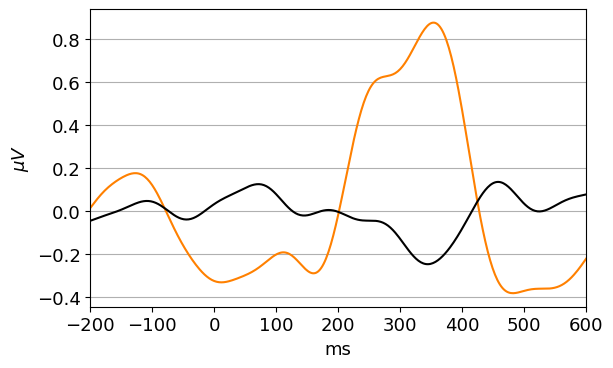

In [12]:
for n_calib in range(len(EEG['train'])):
  cur_EEG = EEG['test'][n_calib]
  data = np.asarray(cur_EEG['data'])
  srate = cur_EEG['srate']
  data = butter_bandpass_filter(data, 1, 10, srate, 4)
  markers = cur_EEG['markers_target']

  targetID = np.where(markers==1)[0]
  nontargetID = np.where(markers==2)[0]

  tmp_targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, True)
  tmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, True)
  if n_calib == 0:
    targetEEG = tmp_targetEEG
    nontargetEEG = tmp_nontargetEEG
  else:
    targetEEG = np.dstack((targetEEG, tmp_targetEEG))
    nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))

avg_target = np.mean(targetEEG, axis=2) # trial average
avg_nontarget = np.mean(nontargetEEG, axis=2) # trial average

# Channel selection for drawing ERPs
elec_midline = [31-1, 32-1, 13-1] # Fz, Cz, and Pz, respectively, -1 for indexing
ch_avg_target = np.mean(avg_target[elec_midline, :], axis=0)
ch_avg_nontarget = np.mean(avg_nontarget[elec_midline, :], axis=0)

# Single subject averaged target & nontarget ERPs - visualization
t = np.linspace(-200, 600, avg_target.shape[1])
plt.plot(t, ch_avg_target.transpose(), color=[1, 0.5, 0])
plt.plot(t, ch_avg_nontarget.transpose(), color=[0, 0, 0])
plt.xlabel('ms')
plt.ylabel(r'$\mu V$')
plt.gca().yaxis.grid(True)
plt.rcParams.update({'font.size': 13})
plt.xlim([-200, 600])

# plot ratio
ratio = .6
x_left, x_right = plt.gca().get_xlim()
y_low, y_high = plt.gca().get_ylim()

plt.gca().set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.show()

### **Pre-processing for training EEG (Xtrain Ytrain Split)**

In [13]:
#Load Dataset

# nsub = 1
# path = "/Volumes/Yohan's_T7/FYP/Datasets/P300 Speller/"
# EEg= mat73.loadmat(path+'s{:02d}.mat'.format(int(nsub))) # 's{:02d}.mat': This is a string specifying the name of the MATLAB file to be loaded. It includes a placeholder ({:02d}) for an integer (nsub), where the integer is formatted with at least two digits (padded with zeros if needed). This suggests that the MATLAB files are named in a structured way, with 's' followed by a two-digit number and ending with '.mat'.

# for i in range(1,55):
#   EEg= mat73.loadmat(path+'s{:02d}.mat'.format(int(nsub)))

In [14]:
for n_calib in range(len(EEG['train'])):
    # print(n_calib)
    cur_eeg = EEG['train'][n_calib]
    data = np.asarray(cur_eeg['data'])
    srate = cur_eeg['srate']
    data = butter_bandpass_filter(data, 0.5, 10, srate, 4)
    markers = cur_eeg['markers_target']

    targetID = np.where(markers==1)[0]
    nontargetID = np.where(markers==2)[0]

    tmp_targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, True)
    tmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, True)
    if n_calib == 0:
        targetEEG = tmp_targetEEG
        nontargetEEG = tmp_nontargetEEG
    else:
        targetEEG = np.dstack((targetEEG, tmp_targetEEG)) # np.dstack is a function that stacks arrays in sequence along the third axis (depth). Given a sequence of arrays with the same shape along the first two dimensions, np.dstack concatenates them along the third axis. The function name "dstack" stands for "depth stack."
        nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))


In [15]:
# data dimension for
print('Target EEG shape', targetEEG.shape) # ch x time x trial                  In one calibration run has 150 target and 750 nontarget events. There are 2 calibration runs, so after stacking shape is Target EEG shape (32, 409, 300),Nontarget EEG shape (32, 409, 1500)
print('Nontarget EEG shape', nontargetEEG.shape) # ch x time x trial


Target EEG shape (32, 409, 300)
Nontarget EEG shape (32, 409, 1500)


In [16]:
print(targetEEG[0,:,1].shape)
targetEEG[0,:,1]

(409,)


array([-6.6474652 , -6.78293908, -6.91457772, -7.041581  , -7.1631452 ,
       -7.27846926, -7.38676124, -7.48724491, -7.57916634, -7.6618003 ,
       -7.73445632, -7.79648394, -7.84727702, -7.88627666, -7.91297266,
       -7.92690318, -7.92765287, -7.91484945, -7.88815899, -7.84728036,
       -7.79193898, -7.72188041, -7.63686405, -7.53665744, -7.42103139,
       -7.28975638, -7.14260037, -6.97932831, -6.79970304, -6.60348791,
       -6.39045065, -6.1603685 , -5.9130346 , -5.64826538, -5.36590904,
       -5.06585507, -4.74804488, -4.41248333, -4.05925125, -3.68851885,
       -3.30055967, -2.89576482, -2.47465706, -2.03790428, -1.58633185,
       -1.12093345, -0.64288013, -0.1535271 ,  0.34558181,  0.85271258,
        1.36594248,  1.88316509,  2.40209897,  2.92030041,  3.43518008,
        3.94402368,  4.44401625,  4.93226981,  5.40585391,  5.86182851,
        6.29727852,  6.70934926,  7.09528228,  7.45245079,  7.77839407,
        8.07085059,  8.32778909,  8.54743744,  8.72830868,  8.86

In [17]:
# training target data
down_target = decimation_by_avg(targetEEG, 24)
down_nontarget = decimation_by_avg(nontargetEEG, 24)

n_frame 409
decimated_frame  17
decimated_data.shape  (32, 17, 300)
n_frame 409
decimated_frame  17
decimated_data.shape  (32, 17, 1500)


In [18]:
print("down_target.shape ", down_target.shape)
print("down_nontarget.shape ", down_nontarget.shape)

ch_target, frame_target, trial_target = down_target.shape
ch_nontarget, frame_nontarget, trial_nontarget = down_nontarget.shape

down_target.shape  (32, 17, 300)
down_nontarget.shape  (32, 17, 1500)


In [19]:
# ch x time x trial -> (ch* time) x trial -> trial x (ch*time)
feat_target = np.reshape(down_target, (ch_target*frame_target, trial_target)).transpose()
feat_nontarget = np.reshape(down_nontarget, (ch_nontarget*frame_nontarget, trial_nontarget)).transpose()


In [20]:
# labels - (+1) for target and (-1) for nontarget
y_target = np.ones((feat_target.shape[0],1))
y_nontarget = -np.ones((feat_nontarget.shape[0],1))

print('Target feature vector shape', feat_target.shape)
print('Nontarget feature vector shape', feat_nontarget.shape)


Target feature vector shape (300, 544)
Nontarget feature vector shape (1500, 544)


In [21]:
feat_train = np.vstack((feat_target, feat_nontarget))
y_train = np.vstack((y_target, y_nontarget))

print('feat_train vector shape', feat_train.shape)
print('y_train vector shape', y_train.shape)

feat_train vector shape (1800, 544)
y_train vector shape (1800, 1)


In [22]:
# shuffle target and nontarget indices
np.random.seed(101)
idx_train = np.arange(feat_train.shape[0])
np.random.shuffle(idx_train)
feat_train = feat_train[idx_train, :]
y_train = y_train[idx_train, :]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(feat_train, y_train, test_size=0.2, random_state=42)

## SVM Classification

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Standardize the features (optional but recommended for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the SVM model
svm_model = SVC(kernel='linear', C=1.0)  # 'linear' kernel for linear SVM
svm_model.fit(X_train, y_train)

/Users/yohanabeysinghe/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear')

In [25]:
# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_str)

Accuracy: 0.83

Confusion Matrix:
[[268  29]
 [ 31  32]]

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.90      0.90      0.90       297
         1.0       0.52      0.51      0.52        63

    accuracy                           0.83       360
   macro avg       0.71      0.71      0.71       360
weighted avg       0.83      0.83      0.83       360

